In [8]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.preprocessing import image
from keras import layers,models,optimizers
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,Dense,BatchNormalization
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import keras_tuner as kt

In [4]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.3 MB/s eta 0:00:00


In [12]:
class_name=os.listdir('/kaggle/input/brain-tumor-mri-dataset/Training')
class_name

['pituitary', 'notumor', 'meningioma', 'glioma']

In [14]:
datagen=ImageDataGenerator(rescale=1./255)
train=datagen.flow_from_directory(directory='/kaggle/input/brain-tumor-mri-dataset/Training',target_size=(224,224),class_mode='categorical')
test=datagen.flow_from_directory(directory='/kaggle/input/brain-tumor-mri-dataset/Training',target_size=(224,224),class_mode='categorical')

Found 5712 images belonging to 4 classes.
Found 5712 images belonging to 4 classes.


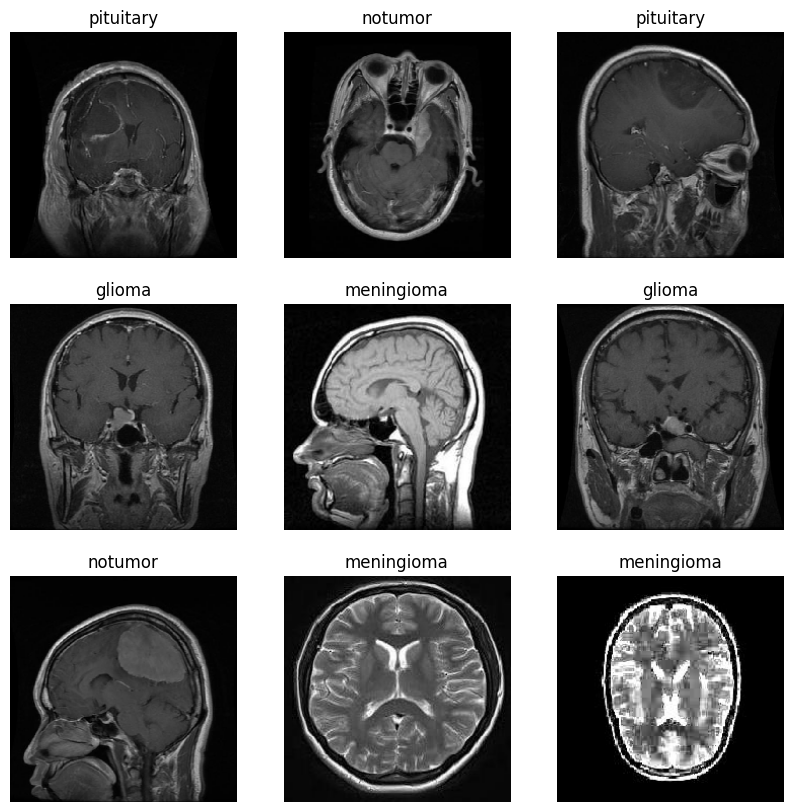

In [15]:
images,labels=next(train)
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    plt.title(class_name[np.argmax(labels[i])])
    plt.axis('off')
plt.show()

In [18]:
train_df=tf.keras.utils.image_dataset_from_directory(directory='/kaggle/input/brain-tumor-mri-dataset/Training',
                                            labels='inferred',
                                            label_mode='int',
                                            batch_size=32,
                                            image_size=(256,256),
                                            shuffle=True,
                                            seed=42)

test_df=tf.keras.utils.image_dataset_from_directory(directory='/kaggle/input/brain-tumor-mri-dataset/Training',
                                           labels='inferred',
                                            label_mode='int',
                                            batch_size=32,
                                            image_size=(256,256),
                                            shuffle=True,
                                            seed=42)


Found 5712 files belonging to 4 classes.
Found 5712 files belonging to 4 classes.


In [19]:
def process(image,label):
    image=tf.cast(image/255.0,tf.float32)
    return image,label
train_df=train_df.map(process)
test_df=test_df.map(process)

In [20]:
train_df

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# CNN arch.

In [21]:
model=Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D((2,2),strides=2, padding='valid'))


model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2),strides=2, padding='valid'))


model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2),strides=2, padding='valid'))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(4,activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,260 (56.64 MB)

 Trainable params: 14,847,876 (56.64 MB)

 Non-trainable params: 384 (1.50 KB)

In [23]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history=model.fit(train_df,epochs=10,validation_data=test_df)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 32s 149ms/step - accuracy: 0.8217 - loss: 0.4899 - val_accuracy: 0.8797 - val_loss: 0.3441
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 32s 118ms/step - accuracy: 0.8884 - loss: 0.3135 - val_accuracy: 0.9415 - val_loss: 0.1685
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 40s 113ms/step - accuracy: 0.9264 - loss: 0.2204 - val_accuracy: 0.9520 - val_loss: 0.1492
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step - accuracy: 0.9310 - loss: 0.1907 - val_accuracy: 0.9800 - val_loss: 0.0655
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - accuracy: 0.9560 - loss: 0.1294 - val_accuracy: 0.9895 - val_loss: 0.0458
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 21s 118ms/step - accuracy: 0.9621 - loss: 0.1186 - val_accuracy: 0.9926 - val_loss: 0.0270
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 39s 107ms/step - accuracy: 0.9758 - loss: 0.0708 - val_accuracy: 0.9904 - val_loss: 0.0294
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 22s 118ms/step - accuracy: 0.9834 - loss: 0

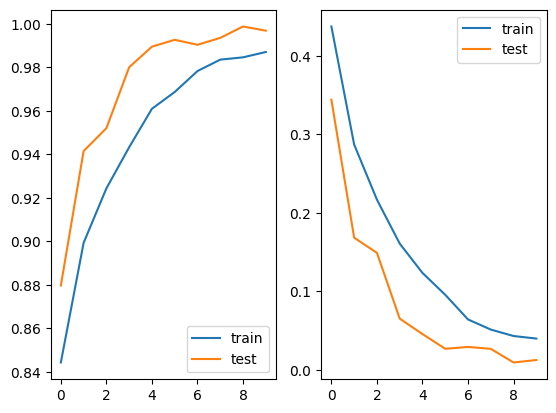

In [24]:
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='test')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.show()

In [25]:
preds=np.argmax(model.predict(test_df),axis=1)

179/179 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step


In [26]:
import numpy as np

# Collect true labels
true_labels = []
for batch_images, batch_labels in test_df:
    true_labels.extend(batch_labels.numpy())

true_labels = np.array(true_labels)

<Figure size 1000x3000 with 0 Axes>

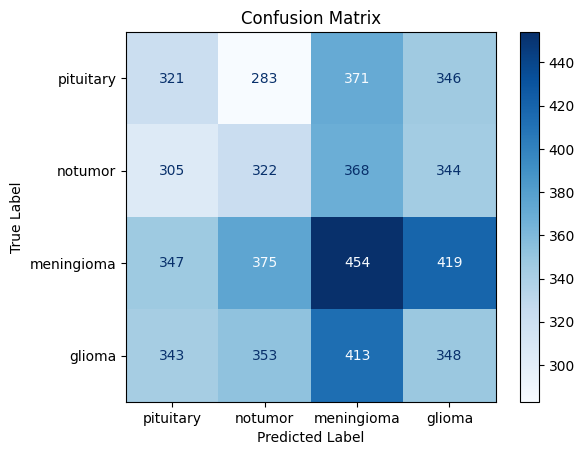

In [27]:
cm=confusion_matrix(true_labels,preds)
plt.figure(figsize=(10,30))
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_name)
disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix')
disp.ax_.set_xlabel('Predicted Label')
disp.ax_.set_ylabel('True Label')
plt.show()

In [31]:
test_image=tf.keras.utils.load_img('/content/sample_data/Midline Glioma (Article).jpg',
                                   target_size=(256,256))
test_image=tf.keras.utils.img_to_array(test_image)
test_image=test_image/255.0
test_image=np.expand_dims(test_image,axis=0)
test_preds=model.predict(test_image)
class_name[np.argmax(test_preds)]


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


'meningioma'

In [32]:
test_image=tf.keras.utils.load_img('/content/sample_data/br.jpg',
                                   target_size=(256,256))
test_image=tf.keras.utils.img_to_array(test_image)
test_image=test_image/255.0
test_image=np.expand_dims(test_image,axis=0)
test_preds=model.predict(test_image)
class_name[np.argmax(test_preds)]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


'notumor'

In [34]:
class_name

['pituitary', 'notumor', 'meningioma', 'glioma']

In [40]:
import joblib
from google.colab import files

In [37]:
joblib.dump(model,'brain_tumor_model.h5')


['brain_tumor_model.h5']

#done

In [41]:
files.download('brain_tumor_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def build_model(hp):
    tuned_model=Sequential()
    tuned_model.add(Conv2D(32,(3,3),activation='relu',input_shape=(256,256,3)))
    tuned_model.add(MaxPooling2D((2,2),strides=2, padding='valid'))
    tuned_model.add(Conv2D(64,(3,3),activation='relu'))
    tuned_model.add(MaxPooling2D((2,2),strides=2, padding='valid'))
    tuned_model.add(Conv2D(128,(3,3),activation='relu'))
    tuned_model.add(MaxPooling2D((2,2),strides=2, padding='valid'))
    tuned_model.add(Flatten())


    for i in range(hp.Int('num_layers',min_value=1,max_value=10)):
        tuned_model.add(layers.Dense(
            units=hp.Int('units_'+str(i),min_value=32,max_value=540,step=np.random.randint(1,10)),
            activation=hp.Choice('activation'+str(i),values=['relu','tanh','sigmoid'])))

        tuned_model.add(layers.Dropout(
            rate=hp.Choice(f'dropout_{i}', values=[0.1, 0.2, 0.3, 0.4, 0.5])
        ))
        tuned_model.add(BatchNormalization())

    tuned_model.add(Dense(4,activation='softmax'))

    tuned_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return tuned_model

In [ ]:
tuned=kt.RandomSearch(build_model,
                      objective='val_accuracy',
                      max_trials=5,
                      directory='/kaggle/working',
                      overwrite=True)
tuned.search(train_df,epochs=10,validation_data=test_df)

In [ ]:
best_params=tuned.get_best_hyperparameters(num_trials=1)[0]
best_params.get_config()['values']

{'num_layers': 7,
 'units_0': 440,
 'activation0': 'relu',
 'dropout_0': 0.2,
 'units_1': 32,
 'activation1': 'relu',
 'dropout_1': 0.1,
 'units_2': 32,
 'activation2': 'relu',
 'dropout_2': 0.1,
 'units_3': 32,
 'activation3': 'relu',
 'dropout_3': 0.1,
 'units_4': 32,
 'activation4': 'relu',
 'dropout_4': 0.1,
 'units_5': 32,
 'activation5': 'relu',
 'dropout_5': 0.1,
 'units_6': 32,
 'activation6': 'relu',
 'dropout_6': 0.1}

In [ ]:
model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D((2,2),strides=2, padding='valid'))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2),strides=2, padding='valid'))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2),strides=2, padding='valid'))

model.add(Conv2D(264,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2),strides=2, padding='valid'))

model.add(Conv2D(512,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2),strides=2, padding='valid'))

model.add(Conv2D(1028,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2),strides=2, padding='valid'))



model.add(Flatten())

model.add(Flatten())
model.add(Flatten())


model.add(Dense(440,activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32,activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(Dense(32,activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(Dense(32,activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(Dense(32,activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())


model.add(Dense(32,activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())


model.add(Dense(32,activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())


model.add(Dense(4,activation='softmax'))

model.summary()



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 28, 28, 264)    │       304,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 14, 14, 264)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 12, 12, 512)    │     1,217,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 4, 4, 1028)     │     4,738,052 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 2, 2, 1028)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4112)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4112)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 4112)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 440)            │     1,809,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 440)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 440)            │         1,760 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │        14,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32)             │           12

 Total params: 8,184,488 (31.22 MB)

 Trainable params: 8,183,224 (31.22 MB)

 Non-trainable params: 1,264 (4.94 KB)

In [ ]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history=model.fit(train_df,epochs=10,validation_data=test_df)

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 189ms/step - accuracy: 0.2891 - loss: 1.7680 - val_accuracy: 0.2614 - val_loss: 2.2491
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.3241 - loss: 1.4716 - val_accuracy: 0.1954 - val_loss: 2.1873
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.3486 - loss: 1.3418 - val_accuracy: 0.2487 - val_loss: 1.6752
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.3664 - loss: 1.3168 - val_accuracy: 0.2614 - val_loss: 25.8471
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.3745 - loss: 1.2686 - val_accuracy: 0.2614 - val_loss: 4.8272
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.3798 - loss: 1.2472 - val_accuracy: 0.2665 - val_loss: 1.7822
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.3702 - loss: 1.2497 - val_accuracy: 0.2563 - val_loss: 1.8998
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.4155 - loss: 1.2088 - val_accuracy: 0.246

In [ ]:
preds=np.argmax(model.predict(test_df),axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step


In [ ]:
best_model=tuned.get_best_models(num_models=1)[0]
best_model.fit(
    train_df,
    epochs=10,
    validation_data=test_df
)
preds=np.argmax(best_model.predict(test_df),axis=1)

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 147ms/step - accuracy: 0.7196 - loss: 0.8175 - val_accuracy: 0.3223 - val_loss: 1.6157
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.4125 - loss: 1.3307 - val_accuracy: 0.2081 - val_loss: 1.8539
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.3496 - loss: 1.3980 - val_accuracy: 0.2487 - val_loss: 1.8197
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.3578 - loss: 1.3543 - val_accuracy: 0.2741 - val_loss: 1.5112
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.3642 - loss: 1.3411 - val_accuracy: 0.1827 - val_loss: 1.6007
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.3544 - loss: 1.3552 - val_accuracy: 0.1954 - val_loss: 1.7865
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.3428 - loss: 1.3262 - val_accuracy: 0.1954 - val_loss: 1.7063
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.3472 - loss: 1.3281 - val_accuracy: 0.195

<Figure size 1000x3000 with 0 Axes>

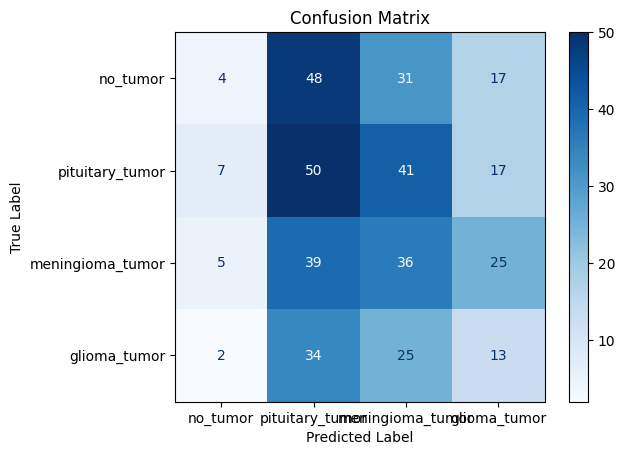

In [ ]:
cm=confusion_matrix(true_labels,preds)
plt.figure(figsize=(10,30))
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_name)
disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix')
disp.ax_.set_xlabel('Predicted Label')
disp.ax_.set_ylabel('True Label')
plt.show()

In [ ]:
test_image=tf.keras.utils.load_img('/content/br.jpg',
                                   target_size=(256,256))
test_image=tf.keras.utils.img_to_array(test_image)
test_image=test_image/255.0
test_image=np.expand_dims(test_image,axis=0)
test_preds=best_model.predict(test_image)
class_name[np.argmax(test_preds)]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step


'no_tumor'

In [ ]:
test_image=tf.keras.utils.load_img('/content/Midline Glioma (Article).jpg',
                                   target_size=(256,256))
test_image=tf.keras.utils.img_to_array(test_image)
test_image=test_image/255.0
test_image=np.expand_dims(test_image,axis=0)
test_preds=best_model.predict(test_image)
class_name[np.argmax(test_preds)]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


'no_tumor'

In [ ]:
true_labels=pd.DataFrame(true_labels)
true_labels

,0
0,1
1,1
2,0
3,2
4,2
...,...
389,3
390,1
391,2
392,1


In [ ]:
true_labels[0].value_counts()

,count
0,
1,115
2,105
0,100
3,74
